# IFCAPOL demo

IFCAPOL is a Python3 implementation of the Matched Filter (MF) and Filtered Fusion (FF, [Argüeso et al. (2009) MNRAS 395, 649–656](https://doi.org/10.1111/j.1365-2966.2009.14549.x)) techniques for the detection/estimation of polarized compact sources in CMB maps. This version of the code is specifically tailored for the LiteBIRD experiment.

- GitLab project at [https://gitlab.com/HerranzD/ifcapol-litebird.git](https://gitlab.com/HerranzD/ifcapol-litebird.git)
- Code documentation will be hosted at readthedocs.org in due time.

### (Please scroll down for updates)

In [1]:
import config
import matplotlib.pyplot as plt
from testing import *
import IFCAPOL as pol

%matplotlib inline

## Testing

We use for testing purposes the map based simulations created by the Foregrounds JSG. In particular, this demo uses one of the 40GHz simulations belonging to the **PTEP_20200915_compsep** run.

### Simulated maps:

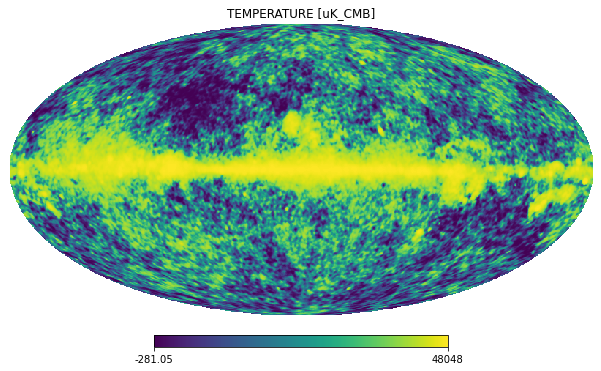

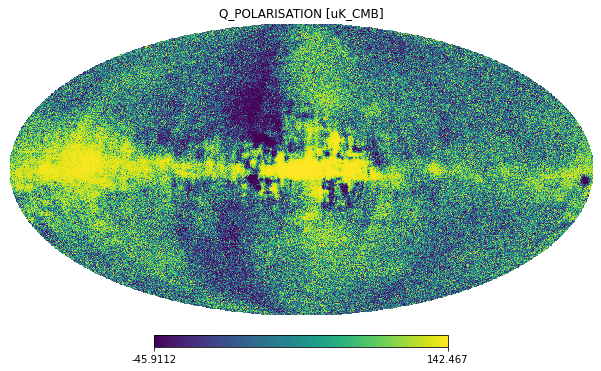

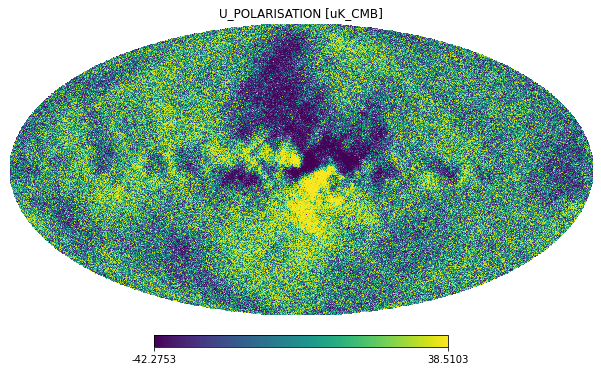

In [2]:
total[0].moll();
total[1].moll();
total[2].moll();

### Simulated radio sources:

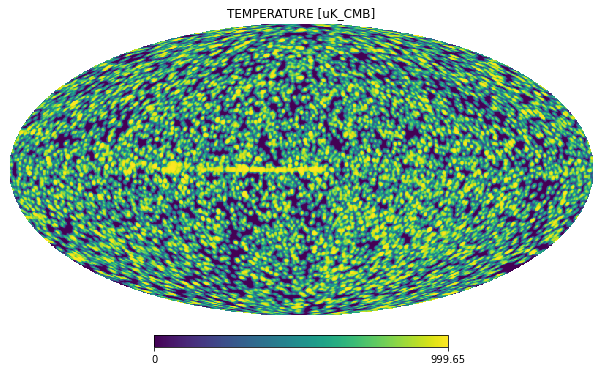

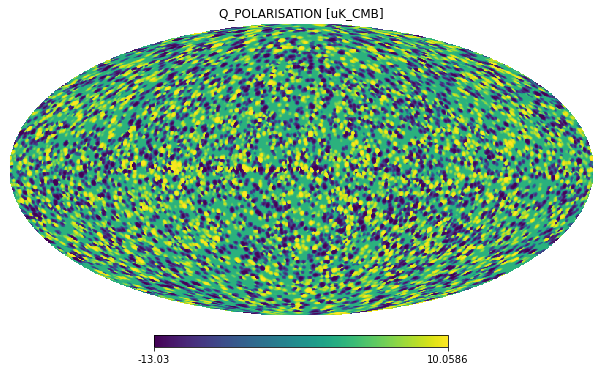

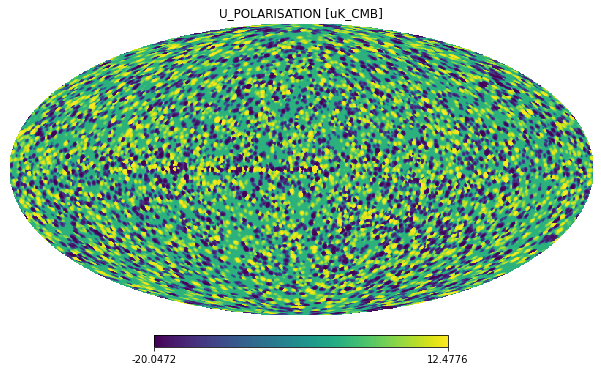

In [3]:
radiops[0].moll();
radiops[1].moll();
radiops[2].moll();

### Testing on the position of a bright source outside the Galactic Plane

In [4]:
coord = total.pixel_to_coordinates(epeaks['Ipix'][10])
print(coord.galactic)

<SkyCoord (Galactic): (l, b) in deg
    (39.69, 43.00863399)>


In [5]:
input_source   = pol.Source.from_coordinate(radiops,coord)
IFCAPOL_source = pol.Source.from_coordinate(total,coord)

- This is the input source:

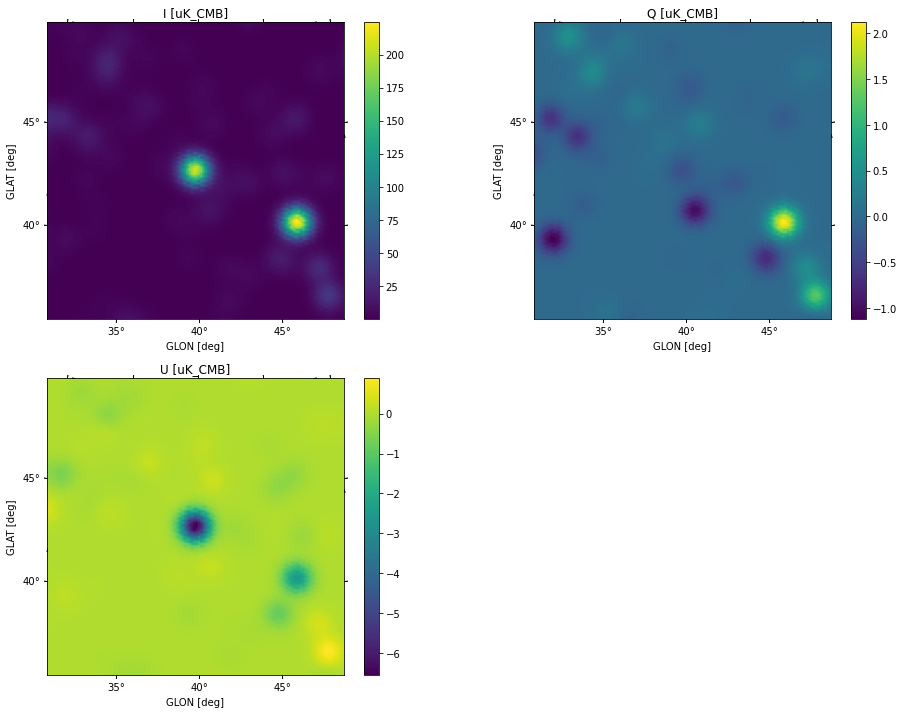

In [6]:
input_source.draw()

In [7]:
print('Source GLON = {0} deg'.format(input_source.coord.galactic.l.deg))
print('Source GLAT = {0} deg'.format(input_source.coord.galactic.b.deg))
print('Source I at its peak = {0} uK'.format(input_source.diccio['Patch I'].datos[64,64]))
print('Source Q at its peak = {0} uK'.format(input_source.diccio['Patch Q'].datos[64,64]))
print('Source U at its peak = {0} uK'.format(input_source.diccio['Patch U'].datos[64,64]))
print('Source P at its peak = {0} uK'.format(np.sqrt(input_source.diccio['Patch Q'].datos[64,64]**2+input_source.diccio['Patch U'].datos[64,64]**2)))

Source GLON = 39.69 deg
Source GLAT = 43.008633994236924 deg
Source I at its peak = 205.0056915283203 uK
Source Q at its peak = -0.30109360814094543 uK
Source U at its peak = -6.474612236022949 uK
Source P at its peak = 6.4816094427018225 uK


- This is the estimated source and its photometry:

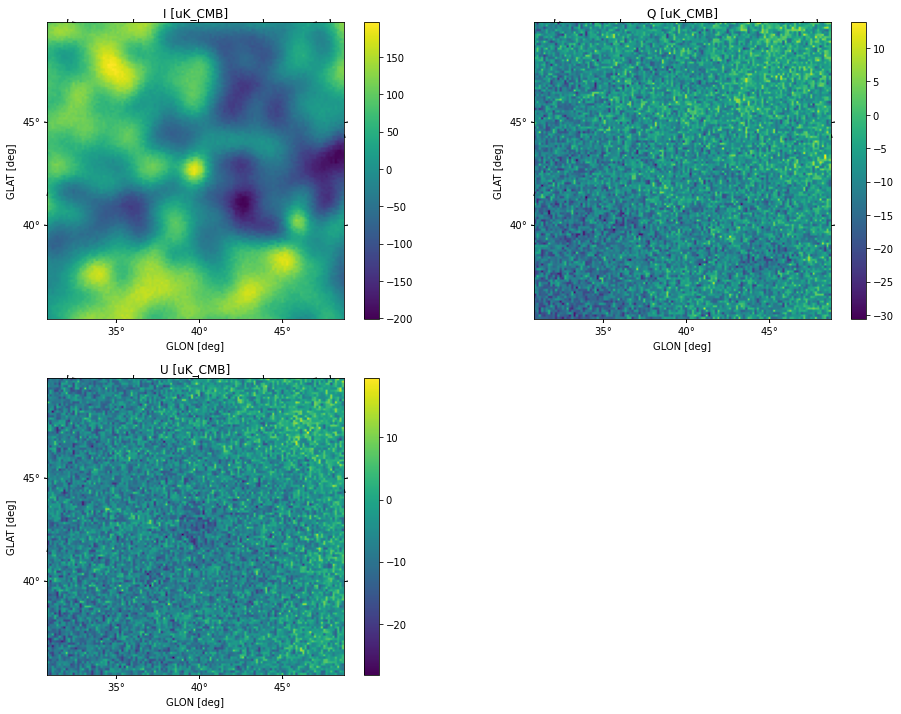

In [8]:
IFCAPOL_source.draw()

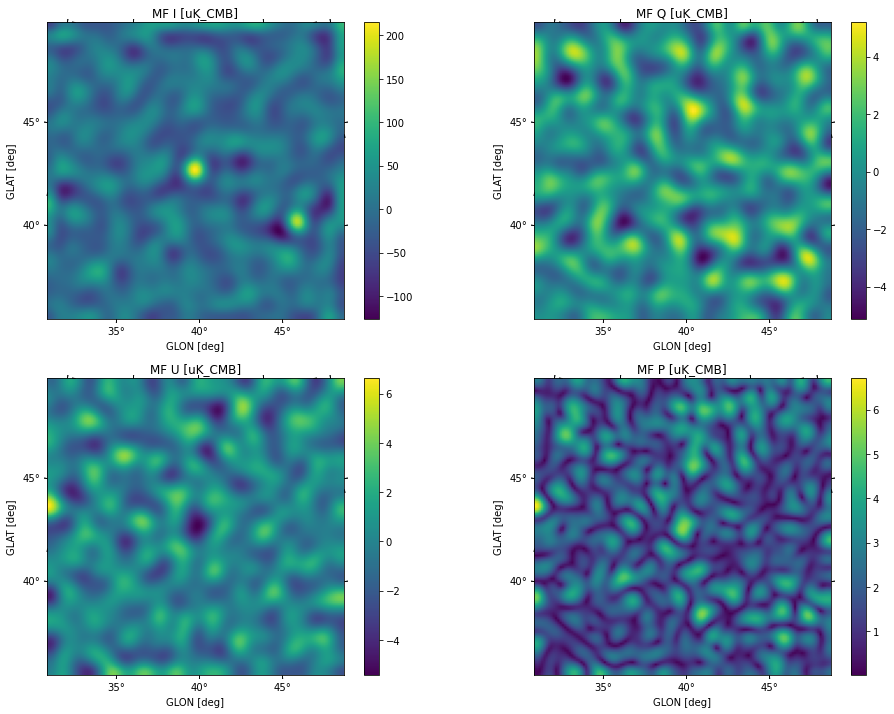

In [9]:
IFCAPOL_source.mfdraw()

In [10]:
print('Estimatemfdrawsource I = {0} +- {1} uK'.format(IFCAPOL_source.I.value,IFCAPOL_source.I.error))
print('Estimated source Q = {0} +- {1} uK'.format(IFCAPOL_source.Q.value,IFCAPOL_source.Q.error))
print('Estimated source U = {0} +- {1} uK'.format(IFCAPOL_source.U.value,IFCAPOL_source.U.error))
print('Estimated source P = {0} +- {1} uK'.format(IFCAPOL_source.P.value,IFCAPOL_source.U.error))

Estimatemfdrawsource I = 216.18111931609636 +- 26.33119761166833 uK
Estimated source Q = -1.3317047201538634 +- 1.7008170174764847 uK
Estimated source U = -5.411169926254355 +- 1.262022363495069 uK
Estimated source P = 5.421001048128357 +- 1.262022363495069 uK


Compare to input:

In [11]:
trueP = np.sqrt(input_source.diccio['Patch Q'].datos[64,64]**2+input_source.diccio['Patch U'].datos[64,64]**2)
print('Source I at its peak = {0} uK'.format(input_source.diccio['Patch I'].datos[64,64]))
print('Source Q at its peak = {0} uK'.format(input_source.diccio['Patch Q'].datos[64,64]))
print('Source U at its peak = {0} uK'.format(input_source.diccio['Patch U'].datos[64,64]))
print('Source P at its peak = {0} uK'.format(trueP))
print(' ')
print('Deviation in I (sigmas) = ',(IFCAPOL_source.I.value-input_source.diccio['Patch I'].datos[64,64])/IFCAPOL_source.I.error)
print('Deviation in Q (sigmas) = ',(IFCAPOL_source.Q.value-input_source.diccio['Patch Q'].datos[64,64])/IFCAPOL_source.Q.error)
print('Deviation in U (sigmas) = ',(IFCAPOL_source.U.value-input_source.diccio['Patch U'].datos[64,64])/IFCAPOL_source.U.error)
print('Deviation in P (sigmas) = ',(IFCAPOL_source.P.value-trueP)/IFCAPOL_source.P.error)

Source I at its peak = 205.0056915283203 uK
Source Q at its peak = -0.30109360814094543 uK
Source U at its peak = -6.474612236022949 uK
Source P at its peak = 6.4816094427018225 uK
 
Deviation in I (sigmas) =  0.4244177554166316
Deviation in Q (sigmas) =  -0.6059506116313698
Deviation in U (sigmas) =  0.842649338497835
Deviation in P (sigmas) =  -0.8214751225749384


## Update: 2022/03/25

We have completed a fully working prototype that is able to run in blind mode, that is,  to search for sources on the whole sky without any prior knowledge on the position of the sources. The code runs in two steps: first we look for these sources and create a list of candidate targets.  Then we go back to the maps and analyse in more detail these candidates in order to get the best photometric and polarimetric estimations we can.  This is working and it takes around 20 minutes in a laptop to process a simulation.

### Default sky patching

For the blind search, we project the sky into 768 partially overlapping flat patches, each of them covering 14.658x14.658 sq degrees. The patch size represents a good compromise between having enough pixels for computing statistics and not having too strong image distortions due to the projection. With this number of patches we are able to cover almost four times the whole sky. 

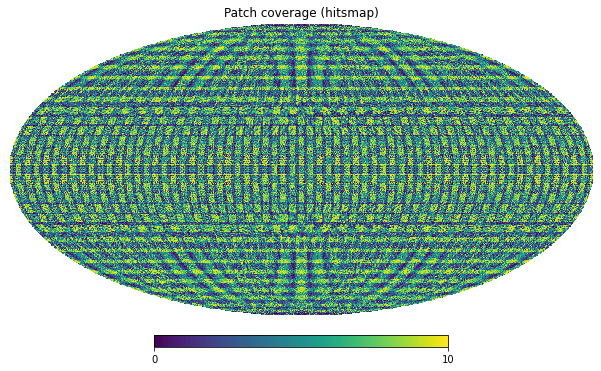

In [12]:
from fits_maps import Fitsmap
hitsmap_name = '/Users/herranz/Dropbox/Trabajo/LiteBird/Source_Extractor/Tests/counts_nside8.fits'
hits = Fitsmap.from_file(hitsmap_name)
hits.moll()
plt.title('Patch coverage (hitsmap)');

## Test catalogue at 40 GHz

We take as an example a blind catalogue generated by IFCAPOL at the 40 GHz channel

In [13]:
from astropy.table import Table
catalogue_fname = '/Users/herranz/Dropbox/Trabajo/LiteBird/Source_Extractor/Catalogs/Output/40GHz_output_catalogue_IFCAPOL.fits'
blindcat40 = Table.read(catalogue_fname) 

This is an example of the output created by IFCAPOL:

In [14]:
blindcat40

<Table length=1171>
  ID       RA [deg]           DEC [deg]      ... Extended flag Photometry flag
int64      float64             float64       ...      bool           bool     
----- ------------------ ------------------- ... ------------- ---------------
    1   83.8708061459378 -5.3637391243285375 ...          True            True
    2  275.0191439160836 -16.073998434575696 ...          True            True
    3 290.72792244481684  14.277087259011191 ...          True            True
    4 155.85434562931945  -57.83356363381737 ...          True            True
    5  83.52722092871227  21.939888895068712 ...          True            True
    6  161.1958295848139 -59.703007886106484 ...          True            True
    7  266.5961693218974  -28.77099480096583 ...          True            True
    8  281.9533269288578 -1.9770644367923602 ...          True            True
    9  124.4451032443245  59.876533492902276 ...         False           False
   10 134.80834804438393  -47.45952627952851 ...          True            True
  ...                ...                 ... ...           ...             ...
 1162  356.1107848943894  -18.25078949018538 ...          True            True
 1163 169.74478421503844  22.666842248575918 ...          True            True
 1164 50.931942733852836   34.32696872247402 ...          True            True
 1165 257.83844510394124   46.09478901609732 ...          True           False
 1166  74.83772127521037   70.15781992377914 ...          True           False
 1167  43.54959981942349 -38.893017528971455 ...          True            True
 1168 182.86049298162183  -47.55473911135006 ...          True           False
 1169  19.32559509083278  -51.57693927834091 ...          True            True
 1170 60.925811373919906  -2.442633719508474 ...          True            True
 1171 138.29919335433067  -45.58390259721883 ...          True            True

Let us cut the catalogue so that in only includes sources detected at the 4sigma level in intensity:

In [15]:
cat4sigma = blindcat40[blindcat40['I SNR']>=4.0]
print(' We have {0} objects detected above the 4sigma level'.format(len(cat4sigma)))

 We have 171 objects detected above the 4sigma level


Let's plot them over the temperature map:

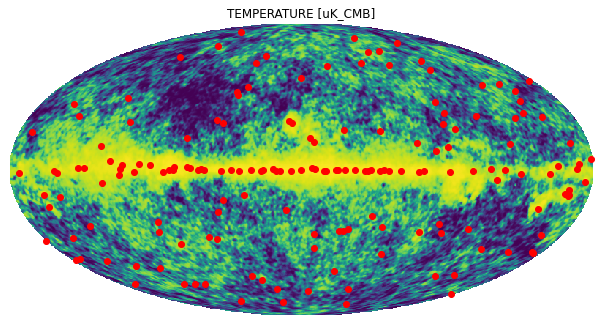

In [16]:
import healpy as hp

t = total[0]
t.moll(norm='hist',cbar=False,flip='astro')

x = cat4sigma['GLON [deg]']
y = cat4sigma['GLAT [deg]']
hp.projscatter(x, y, lonlat=True, coord='G',color='r',marker='o');

Now we need to assess the quality of this catalogue: completeness, reliability, purity. Code for this task is under develepment.